*Manual*        
* Register https://urs.earthdata.nasa.gov/users/new           
* Get Map Ket  normal user 1000 transaccions/10 minuts  (52536e8e34cf07bde80f3177cdcd7771)
* 

# Get start

## Explore data

### Download data from firms

In [177]:
import requests
import pandas as pd
import numpy as np
from io import StringIO
from datetime import datetime, timedelta
import webbrowser

import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from geodatasets import get_path

import folium



In [216]:
# Texas cordenates 
extent = [-106.6, 25.8, -93.5, 36.5]
min_lon, min_lat, max_lon, max_lat = "-106.6","25.8","-93.5","36.5"
cordate_list = ",".join([min_lon, min_lat, max_lon, max_lat])
map_key = "52536e8e34cf07bde80f3177cdcd7771"
url = f'https://firms.modaps.eosdis.nasa.gov/api/area/csv/{map_key}/'
# Fire season is summer  june_1 to september 28  june(31), july(30) august(31), september(30)
start_date = datetime(2022, 6, 1)
days = 50
iterations = int(days/10)

In [239]:
def read_excel_file(response, iteration,requests_day):
    try:
        df = pd.read_csv(StringIO(response))
        print(f"Response {iteration} -- {requests_day} read correctly with {len(df)} fires detected")
        return df
    except FileNotFoundError:
        print(f"The file '{response}' was not found.")
        return None
    except pd.errors.ParserError:
        print("Error while parsing the file.")
        return None
def save_transformed_data(df, output_path):
    if df is not None:
        try:
            df.to_csv(output_path, index=False)
            print("Data Frame saved correctly ")

        except Exception as e:
            print(f"An error occurred while saving the transformed data: {str(e)}")

def dowload_and_tranform_data(cordate_list,map_key,start_date,iterations):
    data_frames = []
    requests_day = start_date
    for i in range(iterations):
        # url_test = f"https://firms.modaps.eosdis.nasa.gov/api/area/csv/{map_key}/VIIRS_NOAA20_NRT/{cordate_list}/10/{requests_day.strftime('%Y-%m-%d')}"
        url_test = f"https://firms.modaps.eosdis.nasa.gov/api/area/csv/{map_key}/LANDSAT_NRT/{cordate_list}/10/{requests_day.strftime('%Y-%m-%d')}"
        response = requests.get(url_test)
        if response.status_code == 200:
            df = read_excel_file(response.text, i,requests_day)
            data_frames.append(df)
            
        else:
            print(f"Error en la solicitud: {response.status_code}")
        requests_day += timedelta(days=10)
    final_df = pd.concat(data_frames, ignore_index=True)
    return final_df

data_set = dowload_and_tranform_data(cordate_list,map_key,start_date,iterations)
data_set = data_set.drop_duplicates()
save_transformed_data(data_set, "./final_df.csv")

Response 0 -- 2022-06-01 00:00:00 read correctly with 0 fires detected
Response 1 -- 2022-06-11 00:00:00 read correctly with 155 fires detected
Response 2 -- 2022-06-21 00:00:00 read correctly with 2481 fires detected
Response 3 -- 2022-07-01 00:00:00 read correctly with 2039 fires detected
Response 4 -- 2022-07-11 00:00:00 read correctly with 703 fires detected
Data Frame saved correctly 


C:\Users\fabri\AppData\Local\Temp\ipykernel_14396\1956136400.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(data_frames, ignore_index=True)


In [240]:
# data_set['acq_date'] = pd.to_datetime(data_set['acq_date'])

data_set.head()


,latitude,longitude,path,row,scan,track,acq_date,acq_time,satellite,confidence,daynight
0,33.80530,-97.71139,28,36,5513,6840,2022-06-20,1707,L9,H,D
1,33.80531,-97.71171,28,36,5512,6840,2022-06-20,1707,L9,L,D
2,33.80558,-97.71171,28,36,5512,6839,2022-06-20,1707,L9,L,D
3,34.08172,-97.40484,28,36,6443,5805,2022-06-20,1707,L9,H,D
4,34.08172,-97.40517,28,36,6442,5805,2022-06-20,1707,L9,H,D


In [219]:
data_set["confidence"].unique()

array(['H', 'L', 'M'], dtype=object)

### group fire by proximity

In [ ]:


# Sort the data by datetime and location for easier comparison
fire_data_sorted = data_set.sort_values(by=['latitude', 'longitude'])

# Define a function to calculate Euclidean distance between two points
def calculate_distance_with_hervesine(lat1, lon1, lat2, lon2):
    # Approximate radius of earth in km
    R = 6371.0
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c * 1000 # Convert to meters
    return distance

# Add columns for lat/lon difference and time difference to the sorted data
fire_data_sorted['lat_diff'] = fire_data_sorted['latitude'].diff().abs()
fire_data_sorted['lon_diff'] = fire_data_sorted['longitude'].diff().abs()

# Calculate spatial distance between consecutive observations
fire_data_sorted['spatial_distance'] = fire_data_sorted.apply(lambda row: calculate_distance_with_hervesine(row['latitude'], row['longitude'], 
                                                                                              row['latitude'] - row['lat_diff'], 
                                                                                              row['longitude'] - row['lon_diff']), axis=1)

# Show the updated dataframe
fire_data_sorted.head()


: 

In [ ]:
# Define thresholds for clustering
spatial_threshold = 60  # 60 meters
temporal_threshold = pd.Timedelta('24 hours')  # 24 hours

# Initialize fire cluster id
fire_data_sorted['fire_cluster'] = 0
current_cluster_id = 1

# Iterate over the sorted data to assign fire cluster ids
for i in range(1, len(fire_data_sorted)):
    if (fire_data_sorted.iloc[i]['spatial_distance'] <= spatial_threshold) :
        fire_data_sorted.at[fire_data_sorted.index[i], 'fire_cluster'] = current_cluster_id
    else:
        current_cluster_id += 1
        fire_data_sorted.at[fire_data_sorted.index[i], 'fire_cluster'] = current_cluster_id

# Display some of the data to verify the clustering
fire_data_sorted[['latitude', 'longitude', 'acq_date', 'spatial_distance', 'fire_cluster']].head(10)


: 

In [22]:
# Group by fire_cluster to calculate properties of each fire event
#     start_time=pd.NamedAgg(column='acq_datetime', aggfunc='min'),
#    end_time=pd.NamedAgg(column='acq_datetime', aggfunc='max'),
def create_number_list(series):
    return list(series)

fire_events = fire_data_sorted.groupby(['fire_cluster','acq_date']).agg(
    min_latitude=pd.NamedAgg(column='latitude', aggfunc='min'),
    max_latitude=pd.NamedAgg(column='latitude', aggfunc='max'),
    min_longitude=pd.NamedAgg(column='longitude', aggfunc='min'),
    max_longitude=pd.NamedAgg(column='longitude', aggfunc='max'),
    detections=pd.NamedAgg(column='latitude', aggfunc='count'),
    concat_latitude = pd.NamedAgg(column='latitude',  aggfunc=lambda x: list(x)), 
    concat_longitude = pd.NamedAgg(column='longitude',  aggfunc=lambda x: list(x))
).reset_index()

# Calculate duration and area for each fire event
#fire_events['duration'] = fire_events['end_time'] - fire_events['start_time']
fire_events['area'] = np.pi * (30 ** 2) * fire_events['detections']  # Area per detection assuming 30m radius

#Get a avg position
fire_events["mean_latitude"] = (fire_events["max_latitude"]  + fire_events["max_latitude"]) /2
fire_events["mean_longitude"] = (fire_events["min_longitude"]  + fire_events["max_longitude"]) /2
# Sort fire events by area
top_fires = fire_events.sort_values(by='area', ascending=False).head(10)


# Display the top 10 fire events
top_fires[['detections', 'area', 'min_latitude','max_latitude', 'min_longitude','max_longitude',"mean_longitude","mean_latitude","concat_latitude","concat_longitude"]]


NameError: name 'fire_data_sorted' is not defined

## Start proyect

### Graph fires

In [142]:
def plot_fire_mini(x, y):
    fig, ax1 = plt.subplots(figsize=(6, 3))  # Use plt.subplots to create a figure and axes

    ax1.scatter(x, y, s=20, edgecolors='k', c='b', label='a')
    ax1.legend()
    ax1.set_title('classic')

    plt.show()  # Show the plot


<Axes: >

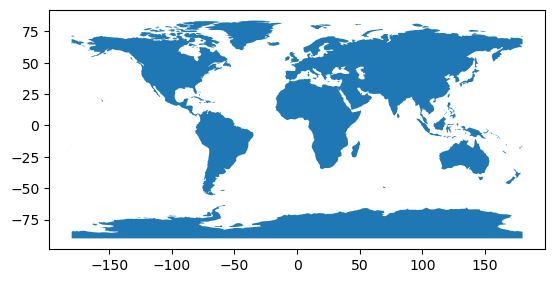

In [181]:
path = get_path("naturalearth.land")
world = gpd.read_file(path)

# and test our libraries loaded

world.plot()

In [188]:
def plot_fires_of_day_goepandas(data_frame, title ):
    gdf_all_fires = gpd.GeoDataFrame(
        data_frame,
        geometry=gpd.points_from_xy(data_frame['longitude'], data_frame['latitude']),
        crs="EPSG:4326"
    )
    ax = world.plot(figsize=(10, 10) ,color="grey", edgecolor="black")
    ax.set_xlim([extent[0],  extent[2]])
    ax.set_ylim([extent[1],  extent[3]])
    ax.set(title=title)

    gdf_all_fires.plot(marker='o', color='blue', markersize=5, label='All Fires', ax=plt.gca())

    plt.legend()
    plt.show()

In [164]:
# def plot_fire_day_goepandas(extent, data_frame, title ):
#     gdf = geopandas.GeoDataFrame(
#         data_frame, geometry=geopandas.points_from_xy(data_frame['concat_longitude'][0], data_frame['concat_longitude'][0],), crs="EPSG:4326"
#     )
#     # optional: set outline and fill colors
#     ax = world.plot(figsize=(10, 10), color="grey", edgecolor="black")
#     ax.set_xlim([extent[0],  extent[2]])
#     ax.set_ylim([extent[1],  extent[3]])

#     ax.set(title=title)

#     # We can now plot our ``GeoDataFrame``.
#     gdf.plot(ax=ax, color="red", markersize=0.1)

#     plt.show()


In [ ]:
def radius_from_area(area):
    radius = np.sqrt(area / np.pi)
    return radius

def graph_fire_area_by_mean(row):
    # map cordenates
    latitud = row["mean_latitude"]  
    longitud = row["mean_longitude"]

    # Crea un mapa centrado en las coordenadas especificadas
    mapa = folium.Map(location=[latitud, longitud], zoom_start=15)
    radius = radius_from_area(row["area"])
    # Agrega un círculo al mapa para representar el fuego
    folium.Circle(location=[latitud, longitud], radius=radius, color='red', fill=True, fill_opacity=0.3).add_to(mapa)
    # Agrega un círculo al mapa para representar area 1 
    folium.Circle(location=[latitud, longitud], radius=radius*2, color='yellow', fill=True, fill_opacity=0.3).add_to(mapa)

    # Agrega un círculo al mapa para representar area 2
    folium.Circle(location=[latitud, longitud], radius=radius*4, color='blue', fill=True, fill_opacity=0.3).add_to(mapa)

    # Agrega un marcador en el centro del mapa
    folium.Marker([latitud, longitud], icon=folium.Icon(color='red')).add_to(mapa)

    # Guarda el mapa como un archivo HTML
    mapa.save("mapa.html")

    # Abre el mapa en tu navegador web predeterminado
    webbrowser.open("mapa.html")

graph_fire_area_by_mean(top_fires.iloc[0])


: 

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
# # Create a Basemap object with a specific projection (e.g., Mercator)
# m = Basemap(
#     projection='merc',
#     llcrnrlat=latitude_min,  # Minimum latitude
#     urcrnrlat=latitude_max,  # Maximum latitude
#     llcrnrlon=longitude_min, # Minimum longitude
#     urcrnrlon=longitude_max, # Maximum longitude
#     resolution='i'           # 'c' for crude, 'l' for low, 'i' for intermediate, 'h' for high
# )
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111)
# # Latitude and longitude data (replace with your data)
# latitudes = [latitude1, latitude2, ...]
# longitudes = [longitude1, longitude2, ...]

# # Convert latitude and longitude to map coordinates
# x, y = m(longitudes, latitudes)

# # Plot the data as scatter points
# m.scatter(x, y, marker='o', color='red', label='Data Points')
# m.drawcoastlines()
# m.drawcountries()
# m.drawparallels(range(-90, 91, 10), labels=[1, 0, 0, 0])
# m.drawmeridians(range(-180, 181, 10), labels=[0, 0, 0, 1])

# # Add a title and legend
# plt.title('Scatter Plot of Latitude and Longitude')
# plt.legend(loc='best')
# plt.show()


### Group by buffer, try

In [244]:
test_df = data_set[data_set["acq_date"] == "2022-06-20"]


test_df

C:\Users\fabri\AppData\Local\Temp\ipykernel_14396\4239934557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['latitude'] = test_df['latitude'].round(5)
C:\Users\fabri\AppData\Local\Temp\ipykernel_14396\4239934557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['longitude'] = test_df['longitude'].round(5)


,latitude,longitude,path,row,scan,track,acq_date,acq_time,satellite,confidence,daynight
0,33.80530,-97.71139,28,36,5513,6840,2022-06-20,1707,L9,H,D
1,33.80531,-97.71171,28,36,5512,6840,2022-06-20,1707,L9,L,D
2,33.80558,-97.71171,28,36,5512,6839,2022-06-20,1707,L9,L,D
3,34.08172,-97.40484,28,36,6443,5805,2022-06-20,1707,L9,H,D
4,34.08172,-97.40517,28,36,6442,5805,2022-06-20,1707,L9,H,D
...,...,...,...,...,...,...,...,...,...,...,...
150,26.11912,-99.60258,28,42,6919,3460,2022-06-20,1710,L9,H,D
151,26.11939,-99.60169,28,42,6922,3459,2022-06-20,1710,L9,H,D
152,26.11939,-99.60139,28,42,6923,3459,2022-06-20,1710,L9,H,D
153,26.11966,-99.60169,28,42,6922,3458,2022-06-20,1710,L9,H,D


group data, because there are duplicates detection by other row and path, and we filtered and drop the res


In [245]:
# group data, because there are duplicates detection by other row and path, and we filtered and drop the res
def clean_date_set(test_df):
    test_df = test_df.groupby(["latitude", "longitude","acq_date"]).agg(
        acq_time=pd.NamedAgg(column='acq_time', aggfunc='last'),
        satellite = pd.NamedAgg(column='satellite', aggfunc="last")
    ).reset_index()
    test_df['lat_diff'] = test_df['latitude'].diff()
    test_df['lon_diff'] = test_df['longitude'].diff()
    test_df['latitude'] = test_df['latitude'].round(5)
    test_df['longitude'] = test_df['longitude'].round(5)
    return test_df
clean_date_set_df = clean_date_set(test_df)
print(clean_date_set_df.shape)


(133, 7)


We detect and mark the fires

In [246]:
def is_in_buffer(lat_lon_range, longitude, latitude):
    result = (longitude > lat_lon_range[0]) & (longitude < lat_lon_range[2]) & (latitude > lat_lon_range[1]) & (latitude < lat_lon_range[3])
    return result


def update_buffer(lat_lon_range, min_lon, min_lat, max_lon, max_lat,degres_start ):
    lat_lon_range[0] = min_lon - degres_start
    lat_lon_range[1] = min_lat - degres_start
    lat_lon_range[2] = max_lon + degres_start
    lat_lon_range[3] = max_lat + degres_start
    return lat_lon_range

def grow_the_buffer(lat_lon_range, lon_diff,lat_diff,degres_plus):
    if(lon_diff>0):
        lat_lon_range[2] + degres_plus 
    else : 
        lat_lon_range[0] - degres_plus
    if(lat_diff>0):
        lat_lon_range[3] + degres_plus 
    else : 
        lat_lon_range[1] - degres_plus
    return lat_lon_range

def identify_same_fire(group_position):
    # min_lon, min_lat, max_lon, max_lat
    lat_lon_range = [0,0,0,0]
    date  = ""
    degres_plus = round(35 / (111*100),5)
    degres_start = round(45 / (111*100),5)
    current_cluster_id = 0
    group_position['fire_cluster'] = np.nan

    for i in range(0, len(group_position)):
        if(group_position.iloc[i]['acq_date'] != date):
            date = str(group_position.iloc[i]['acq_date'])
            current_cluster_id = 0
            lat_lon_range = [0,0,0,0]

        if (is_in_buffer(lat_lon_range, group_position.iloc[i]['longitude'],group_position.iloc[i]['latitude'])):
            group_position.at[i, 'fire_cluster'] = "fire-" + date + "-" + str(current_cluster_id)
            lat_lon_range = grow_the_buffer(lat_lon_range,group_position.iloc[i]['lon_diff'],group_position.iloc[i]['lat_diff'] ,degres_plus)
        else: 
            lat_lon_range = update_buffer(lat_lon_range, group_position.iloc[i]['longitude'],group_position.iloc[i]['latitude'], group_position.iloc[i]['longitude'],group_position.iloc[i]['latitude'],degres_start)
            current_cluster_id = current_cluster_id + 1
            group_position.at[i, 'fire_cluster'] = "fire-" + date + "-" + str(current_cluster_id)
    return group_position
identified_fires =  identify_same_fire(clean_date_set_df)
identified_fires

C:\Users\fabri\AppData\Local\Temp\ipykernel_14396\3736132517.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'fire-2022-06-20-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group_position.at[i, 'fire_cluster'] = "fire-" + date + "-" + str(current_cluster_id)


,latitude,longitude,acq_date,acq_time,satellite,lat_diff,lon_diff,fire_cluster
0,25.80577,-100.35629,2022-06-20,1710,L9,NaN,NaN,fire-2022-06-20-1
1,25.80604,-100.35660,2022-06-20,1710,L9,0.00027,-0.00031,fire-2022-06-20-1
2,25.80604,-100.35630,2022-06-20,1710,L9,0.00000,0.00030,fire-2022-06-20-1
3,25.82600,-100.03718,2022-06-20,1710,L9,0.01996,0.31912,fire-2022-06-20-2
4,25.83091,-100.24045,2022-06-20,1710,L9,0.00491,-0.20327,fire-2022-06-20-3
...,...,...,...,...,...,...,...,...
128,35.94200,-97.89911,2022-06-20,1707,L9,0.00000,0.00033,fire-2022-06-20-74
129,35.94227,-97.89977,2022-06-20,1707,L9,0.00027,-0.00066,fire-2022-06-20-74
130,35.94227,-97.89944,2022-06-20,1707,L9,0.00000,0.00033,fire-2022-06-20-74
131,35.94227,-97.89911,2022-06-20,1707,L9,0.00000,0.00033,fire-2022-06-20-74


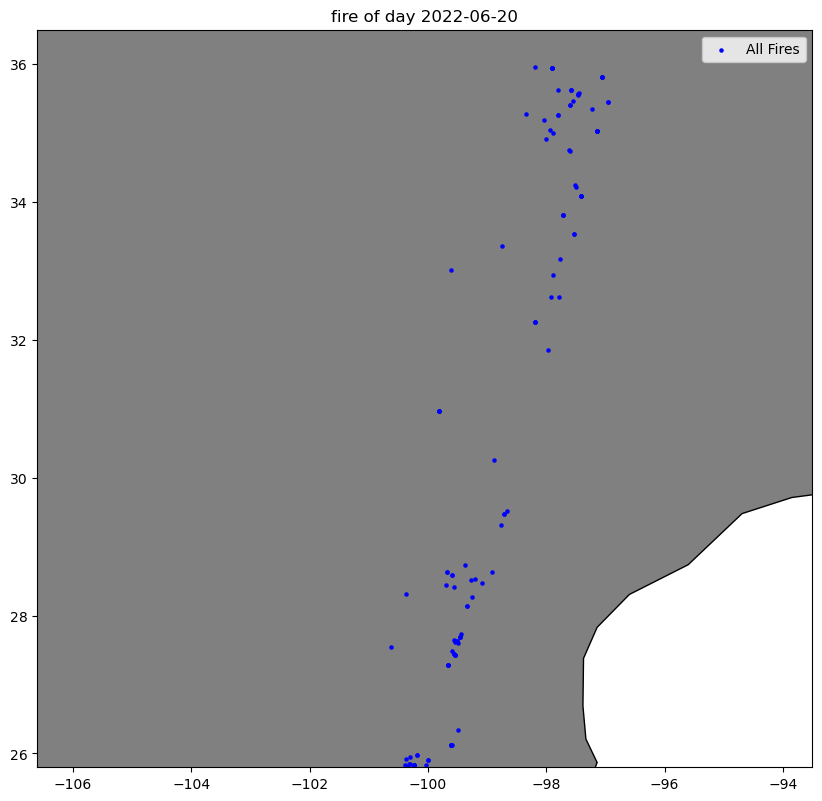

In [189]:
plot_fires_of_day_goepandas(identified_fires, "fire of day 2022-06-20" )

We group the same fires and get a semi buffer and concat their coordenates

In [247]:
def group_fires(identified_fires):
    grouped_fire_df = identified_fires.groupby(['fire_cluster']).agg(
        acq_date=pd.NamedAgg(column='acq_date', aggfunc='first'),        
        min_latitude=pd.NamedAgg(column='latitude', aggfunc='min'),
        max_latitude=pd.NamedAgg(column='latitude', aggfunc='max'),
        min_longitude=pd.NamedAgg(column='longitude', aggfunc='min'),
        max_longitude=pd.NamedAgg(column='longitude', aggfunc='max'),
        detections=pd.NamedAgg(column='latitude', aggfunc='count'),
        mean_latitude=pd.NamedAgg(column='latitude', aggfunc='mean'),
        mean_longitude=pd.NamedAgg(column='longitude', aggfunc='mean'),
        concat_latitude = pd.NamedAgg(column='latitude',  aggfunc=lambda x: list(x)), 
        concat_longitude = pd.NamedAgg(column='longitude',  aggfunc=lambda x: list(x))
    ).reset_index()
    grouped_fire_df['area'] = np.pi * (30 ** 2) * grouped_fire_df['detections']  # Area per detection assuming 30m radius

    return grouped_fire_df
grouped_fire_df =  group_fires(identified_fires)
grouped_fire_df

,fire_cluster,acq_date,min_latitude,max_latitude,min_longitude,max_longitude,detections,mean_latitude,mean_longitude,concat_latitude,concat_longitude,area
0,fire-2022-06-20-1,2022-06-20,25.80577,25.80604,-100.35660,-100.35629,3,25.805950,-100.356397,"[25.80577, 25.80604, 25.80604]","[-100.35629, -100.3566, -100.3563]",8482.300165
1,fire-2022-06-20-10,2022-06-20,25.97436,25.97436,-100.18892,-100.18862,2,25.974360,-100.188770,"[25.97436, 25.97436]","[-100.18892, -100.18862]",5654.866776
2,fire-2022-06-20-11,2022-06-20,26.11885,26.11966,-99.60288,-99.60139,7,26.119159,-99.602113,"[26.11885, 26.11885, 26.11885, 26.11912, 26.11...","[-99.60288, -99.60258, -99.60198, -99.60258, -...",19792.033718
3,fire-2022-06-20-12,2022-06-20,26.34653,26.34653,-99.49402,-99.49402,1,26.346530,-99.494020,[26.34653],[-99.49402],2827.433388
4,fire-2022-06-20-13,2022-06-20,27.28412,27.28467,-99.65513,-99.65482,4,27.284395,-99.654972,"[27.28412, 27.28439, 27.2844, 27.28467]","[-99.65512, -99.65513, -99.65482, -99.65482]",11309.733553
...,...,...,...,...,...,...,...,...,...,...,...,...
70,fire-2022-06-20-73,2022-06-20,35.81730,35.81784,-97.06438,-97.06370,4,35.817505,-97.063878,"[35.8173, 35.81731, 35.81757, 35.81784]","[-97.06372, -97.06438, -97.06371, -97.0637]",11309.733553
71,fire-2022-06-20-74,2022-06-20,35.94200,35.94227,-97.89978,-97.89911,6,35.942135,-97.899442,"[35.942, 35.942, 35.942, 35.94227, 35.94227, 3...","[-97.89978, -97.89944, -97.89911, -97.89977, -...",16964.600329
72,fire-2022-06-20-75,2022-06-20,35.95482,35.95482,-98.18369,-98.18369,1,35.954820,-98.183690,[35.95482],[-98.18369],2827.433388
73,fire-2022-06-20-8,2022-06-20,25.92478,25.92478,-100.37413,-100.37413,1,25.924780,-100.374130,[25.92478],[-100.37413],2827.433388


In [191]:
sorted_fires_df = grouped_fire_df.sort_values(["detections"],ascending=False)
sorted_fires_df.describe()


,min_latitude,max_latitude,min_longitude,max_longitude,detections,area
count,75.000000,75.000000,75.000000,75.00000,75.000000,75.000000
mean,30.747095,30.747250,-98.790244,-98.79009,1.773333,5013.981875
std,3.658742,3.658738,1.061550,1.06152,1.381082,3904.917253
min,25.805770,25.806040,-100.621220,-100.62122,1.000000,2827.433388
25%,27.622835,27.622970,-99.595155,-99.59500,1.000000,2827.433388
50%,29.467750,29.468020,-98.911040,-98.91104,1.000000,2827.433388
75%,34.744025,34.744025,-97.796965,-97.79696,2.000000,5654.866776
max,35.954820,35.954820,-96.961770,-96.96176,7.000000,19792.033718


Get the top fore of the day

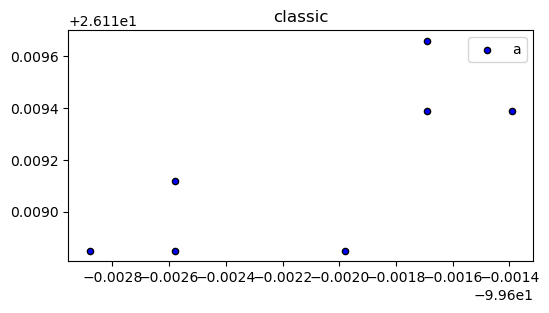

In [159]:
max_fire = sorted_fires_df.head(1)

x = np.array(max_fire["concat_longitude"].explode(), dtype=float)
y = np.array(max_fire["concat_latitude"].explode(), dtype=float)

plot_fire_mini(x,y)

### Group fire by consecutive days 

In [243]:
data_set

,latitude,longitude,path,row,scan,track,acq_date,acq_time,satellite,confidence,daynight
0,33.80530,-97.71139,28,36,5513,6840,2022-06-20,1707,L9,H,D
1,33.80531,-97.71171,28,36,5512,6840,2022-06-20,1707,L9,L,D
2,33.80558,-97.71171,28,36,5512,6839,2022-06-20,1707,L9,L,D
3,34.08172,-97.40484,28,36,6443,5805,2022-06-20,1707,L9,H,D
4,34.08172,-97.40517,28,36,6442,5805,2022-06-20,1707,L9,H,D
...,...,...,...,...,...,...,...,...,...,...,...
5373,26.88270,-104.01295,30,41,1215,5893,2022-07-20,1722,L9,H,D
5374,26.88270,-104.01325,30,41,1214,5893,2022-07-20,1722,L9,H,D
5375,26.88296,-104.01234,30,41,1217,5892,2022-07-20,1722,L9,H,D
5376,26.88297,-104.01264,30,41,1216,5892,2022-07-20,1722,L9,L,D


Get identifiers by buffer

In [252]:
test_df = data_set[data_set["acq_date"]=="2022-06-21"]
clean_date_set_df = clean_date_set(test_df)
identified_fires_df =  identify_same_fire(clean_date_set_df)
grouped_fire_df =  group_fires(identified_fires_df)
grouped_fire_df.head(10)

C:\Users\fabri\AppData\Local\Temp\ipykernel_14396\3736132517.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'fire-2022-06-21-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group_position.at[i, 'fire_cluster'] = "fire-" + date + "-" + str(current_cluster_id)


,fire_cluster,acq_date,min_latitude,max_latitude,min_longitude,max_longitude,detections,mean_latitude,mean_longitude,concat_latitude,concat_longitude,area
0,fire-2022-06-21-1,2022-06-21,25.84139,25.84166,-98.73900,-98.73840,5,25.841552,-98.738640,"[25.84139, 25.84139, 25.84166, 25.84166, 25.84...","[-98.7387, -98.7384, -98.739, -98.7387, -98.7384]",14137.166941
1,fire-2022-06-21-10,2022-06-21,25.86882,25.86882,-98.27962,-98.27902,3,25.868820,-98.279320,"[25.86882, 25.86882, 25.86882]","[-98.27962, -98.27932, -98.27902]",8482.300165
2,fire-2022-06-21-100,2022-06-21,33.07248,33.07276,-96.81020,-96.81019,2,33.072620,-96.810195,"[33.07248, 33.07276]","[-96.8102, -96.81019]",5654.866776
3,fire-2022-06-21-101,2022-06-21,33.14025,33.14025,-96.06708,-96.06708,1,33.140250,-96.067080,[33.14025],[-96.06708],2827.433388
4,fire-2022-06-21-102,2022-06-21,33.18189,33.18190,-97.04491,-97.04459,2,33.181895,-97.044750,"[33.18189, 33.1819]","[-97.04459, -97.04491]",5654.866776
5,fire-2022-06-21-103,2022-06-21,33.21711,33.21738,-96.19870,-96.19837,3,33.217203,-96.198483,"[33.21711, 33.21712, 33.21738]","[-96.19838, -96.1987, -96.19837]",8482.300165
6,fire-2022-06-21-104,2022-06-21,33.33478,33.33534,-96.45110,-96.45013,10,33.335062,-96.450614,"[33.33478, 33.33479, 33.3348, 33.33505, 33.335...","[-96.45014, -96.45046, -96.45078, -96.45013, -...",28274.333882
7,fire-2022-06-21-105,2022-06-21,33.40629,33.40683,-96.56254,-96.56253,2,33.406560,-96.562535,"[33.40629, 33.40683]","[-96.56254, -96.56253]",5654.866776
8,fire-2022-06-21-106,2022-06-21,33.65740,33.65740,-96.73856,-96.73824,2,33.657400,-96.738400,"[33.6574, 33.6574]","[-96.73856, -96.73824]",5654.866776
9,fire-2022-06-21-107,2022-06-21,33.65803,33.65936,-95.99400,-95.99266,4,33.658822,-95.993243,"[33.65803, 33.65855, 33.65935, 33.65936]","[-95.994, -95.99333, -95.99266, -95.99298]",11309.733553


44-12 ? Resultado de los fuegos -> sin el tiempo como tiemp son 120

In [253]:
print(grouped_fire_df.shape)

(166, 12)


In [235]:
sorted_fires = grouped_fire_df.sort_values(["mean_longitude","mean_latitude","acq_date"])
sorted_fires.head(10)

,fire_cluster,acq_date,min_latitude,max_latitude,min_longitude,max_longitude,detections,mean_latitude,mean_longitude,concat_latitude,concat_longitude,area
100,fire-2022-07-10-2,2022-07-10,26.93245,26.93245,-105.73346,-105.73346,1,26.932450,-105.733460,[26.93245],[-105.73346],2827.433388
54,fire-2022-07-01-0,2022-07-01,31.56054,35.41060,-106.58428,-93.77587,25,31.788314,-105.462602,"[31.56054, 31.5608, 31.56081, 31.56081, 31.561...","[-106.38266, -106.38298, -106.38267, -106.3823...",70685.834706
112,fire-2022-07-18-0,2022-07-18,28.65929,32.26670,-106.07884,-104.11104,3,31.064140,-104.766973,"[28.65929, 32.26643, 32.2667]","[-106.07884, -104.11104, -104.11104]",8482.300165
87,fire-2022-07-09-0,2022-07-09,29.07134,35.65565,-106.58426,-93.53354,142,34.250798,-104.551181,"[29.07134, 29.82871, 29.84978, 29.84978, 29.85...","[-95.76391, -93.9645, -93.97029, -93.96998, -9...",401495.541129
113,fire-2022-07-18-1,2022-07-18,27.96648,32.21079,-105.29684,-104.05142,3,30.795930,-104.466560,"[27.96648, 32.21052, 32.21079]","[-105.29684, -104.05142, -104.05142]",8482.300165
65,fire-2022-07-03-1,2022-07-03,26.06054,33.83839,-105.55190,-102.04894,36,31.007122,-103.866463,"[26.06054, 28.28977, 28.28977, 28.29004, 28.29...","[-105.5519, -105.50393, -105.50363, -105.50393...",101787.601976
114,fire-2022-07-19-0,2022-07-19,31.78641,32.97473,-104.11135,-102.74425,5,32.302768,-103.676630,"[31.78641, 32.16074, 32.2667, 32.32526, 32.97473]","[-103.68443, -103.82796, -104.11135, -104.0151...",14137.166941
115,fire-2022-07-19-1,2022-07-19,31.20770,36.01293,-104.11136,-102.15965,45,32.474762,-103.325791,"[31.2077, 31.24181, 31.26715, 31.36428, 31.445...","[-103.13108, -103.15088, -103.08864, -103.1803...",127234.502470
66,fire-2022-07-03-2,2022-07-03,31.67668,33.16862,-103.38977,-103.04328,2,32.422650,-103.216525,"[31.67668, 33.16862]","[-103.38977, -103.04328]",5654.866776
64,fire-2022-07-03-0,2022-07-03,31.14895,33.83866,-104.11135,-102.04893,9,32.604948,-103.210394,"[31.14895, 31.81012, 32.26643, 32.2667, 32.325...","[-103.16716, -103.90055, -104.11104, -104.1113...",25446.900494


In [ ]:
def identify_same_fire_in_time(group_position):
    # min_lon, min_lat, max_lon, max_lat
    lat_lon_range = [0,0,0,0]
    date  = ""
    degres_plus = round(35 / (111*100),5)
    degres_start = round(45 / (111*100),5)
    current_cluster_id = 0
    group_position['fire_cluster'] = np.nan

    for i in range(0, len(group_position)):
        if(group_position.iloc[i]['acq_date'] != date):
            date = str(group_position.iloc[i]['acq_date'])
            current_cluster_id = 0

        if (is_in_buffer(lat_lon_range, group_position.iloc[i]['longitude'],group_position.iloc[i]['latitude'])):
            group_position.at[i, 'fire_cluster'] = "fire-" + date + "-" + str(current_cluster_id)
            lat_lon_range = grow_the_buffer(lat_lon_range,group_position.iloc[i]['lon_diff'],group_position.iloc[i]['lat_diff'] ,degres_plus)
        else: 
            lat_lon_range = update_buffer(lat_lon_range, group_position.iloc[i]['longitude'],group_position.iloc[i]['latitude'], group_position.iloc[i]['longitude'],group_position.iloc[i]['latitude'],degres_start)
            current_cluster_id = current_cluster_id + 1
            group_position.at[i, 'fire_cluster'] = "fire-" + date + "-" + str(current_cluster_id)
    return group_position
identified_fires =  identify_same_fire(clean_date_set_df)